# Light Augmentation: Full-Face 

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from collections import Counter


train_dir = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/train'
train_csv = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/train/_classes.csv'
val_dir = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/valid'
val_csv = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/valid/_classes.csv'
test_dir = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/test1'
test_csv = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/test1/_classes.csv'
new_test_dir = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/testinginnewdataset'
new_test_csv = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/testinginnewdataset/_classes.csv'


img_size = (224, 224)  


def load_and_preprocess_data(data_dir, csv_path, img_size):
    """
    Load, resize, rescale images, and calculate class distribution from a directory and a CSV file.

    Args:
        data_dir (str): Path to the directory containing images.
        csv_path (str): Path to the CSV file containing filenames and labels.
        img_size (tuple): Target size for resizing images (width, height).

    Returns:
        data (np.array): Array of resized and rescaled images.
        labels (np.array): Array of corresponding labels.
        class_counts (dict): Dictionary with the number of images in each class.
    """
    
    df = pd.read_csv(csv_path)
    
    
    img_path_column = 'filename'  
    label_column = ' drowsy'     
    
    data = []
    labels = []
    for idx, row in df.iterrows():
        
        img_path = os.path.join(data_dir, row[img_path_column])
        
       
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image {img_path}. Skipping.")
            continue
        
        
        img = cv2.resize(img, img_size)
        
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
       
        img = img.astype('float32') / 255.0
        
        
        data.append(img)
        labels.append(row[label_column])  
    
    
    class_counts = dict(Counter(labels))
    
    
    return np.array(data), np.array(labels), class_counts


train_data, train_labels, train_class_counts = load_and_preprocess_data(train_dir, train_csv, img_size)
val_data, val_labels, val_class_counts = load_and_preprocess_data(val_dir, val_csv, img_size)
test_data, test_labels, test_class_counts = load_and_preprocess_data(test_dir, test_csv, img_size)
new_test_data, new_test_labels, new_test_class_counts = load_and_preprocess_data(new_test_dir, new_test_csv, img_size)


print(f"Training Set: {len(train_data)} images")
print(f"Validation Set: {len(val_data)} images")
print(f"Test Set 1: {len(test_data)} images")
print(f"Test Set 2 (New Test): {len(new_test_data)} images")


print("\nClass distribution in training set:", train_class_counts)
print("Class distribution in validation set:", val_class_counts)
print("Class distribution in test set 1:", test_class_counts)
print("Class distribution in test set 2 (New Test):", new_test_class_counts)


Training Set: 3068 images
Validation Set: 246 images
Test Set 1: 168 images
Test Set 2 (New Test): 409 images

Class distribution in training set: {0: 1531, 1: 1537}
Class distribution in validation set: {1: 123, 0: 123}
Class distribution in test set 1: {1: 70, 0: 98}
Class distribution in test set 2 (New Test): {0: 195, 1: 214}


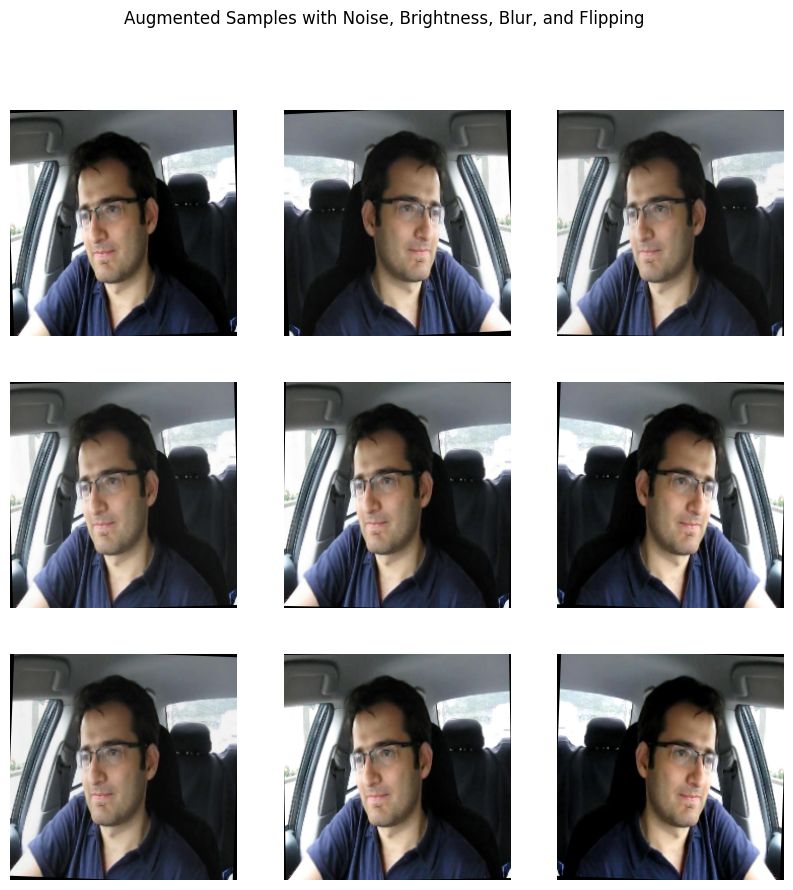

In [17]:
import numpy as np
import imgaug.augmenters as iaa
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV3Small
import matplotlib.pyplot as plt

class ImgAugDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size, augmenter=None, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.augmenter = augmenter
        self.shuffle = shuffle
        self.indices = np.arange(len(self.images))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indices].astype('float32') / 255.0
        batch_labels = self.labels[batch_indices]
        if self.augmenter:
            batch_images = self.augmenter(images=batch_images)
        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

augmenter = iaa.Sequential([
    iaa.LinearContrast((0.9, 1.1)),
    iaa.Multiply((0.95, 1.05)),
    iaa.Affine(rotate=(-3, 3)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.009)),
    iaa.Fliplr(0.3),
    iaa.GaussianBlur(sigma=(0, 0.009))
])

batch_size = 16
train_gen = ImgAugDataGenerator(train_data, train_labels, batch_size, augmenter, shuffle=True)
val_gen = ImgAugDataGenerator(val_data, val_labels, batch_size, augmenter=None, shuffle=False)
test_gen = ImgAugDataGenerator(test_data, test_labels, batch_size, augmenter=None, shuffle=False)
new_test_gen = ImgAugDataGenerator(new_test_data, new_test_labels, batch_size, augmenter=None, shuffle=False)

try:
    
    sample_image = train_data[0]  
    if len(sample_image.shape) == 3:  
        sample_image = np.expand_dims(sample_image, axis=0)  

   
    batch_sample_images = np.repeat(sample_image, 9, axis=0)  

    batch_sample_images_uint8 = (batch_sample_images * 255).astype('uint8')  

    
    augmented_images = augmenter(images=batch_sample_images_uint8)

    
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i])  
        plt.axis('off')
    plt.suptitle("Augmented Samples with Noise, Brightness, Blur, and Flipping")
    plt.show()

except Exception as e:
    print(f"Error during augmentation or visualization: {e}")



### MobileNetV3Small

In [18]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
base_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in base_model.layers[:60]:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3), name='image_input')
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

mobilenet_model = Model(inputs, output)
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32
train_gen = ImgAugDataGenerator(train_data, train_labels, batch_size=batch_size, augmenter=augmenter, shuffle=True)
val_gen = ImgAugDataGenerator(val_data, val_labels, batch_size=batch_size, augmenter=None, shuffle=False)

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

history = mobilenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stopping]
)

Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 116s 986ms/step - accuracy: 0.5090 - loss: 2.1965 - val_accuracy: 0.4866 - val_loss: 1.0880
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 95s 995ms/step - accuracy: 0.5135 - loss: 0.9827 - val_accuracy: 0.5134 - val_loss: 0.7929
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 92s 964ms/step - accuracy: 0.4879 - loss: 0.7688 - val_accuracy: 0.5134 - val_loss: 0.7218
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 884ms/step - accuracy: 0.4981 - loss: 0.7155 - val_accuracy: 0.5134 - val_loss: 0.7016
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 65s 680ms/step - accuracy: 0.5084 - loss: 0.7009 - val_accuracy: 0.5134 - val_loss: 0.6958
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 61s 644ms/step - accuracy: 0.5064 - loss: 0.6966 - val_accuracy: 0.5134 - val_loss: 0.6941
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 69s 725ms/step - accuracy: 0.4926 - loss: 0.6940 - val_accuracy: 0.4866 - val_loss: 0.6936
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 871ms/step - accuracy: 0.4941 - loss: 0.6935 - val_acc

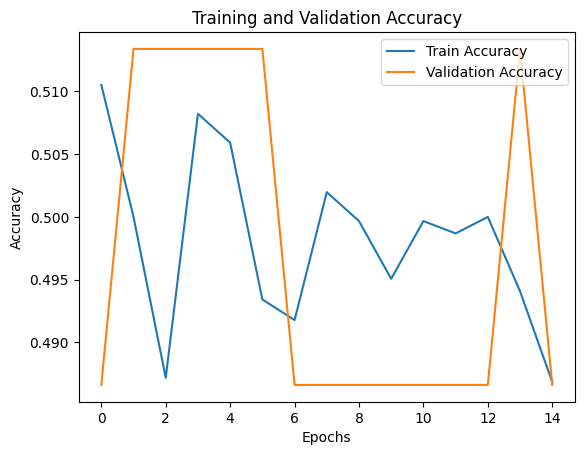

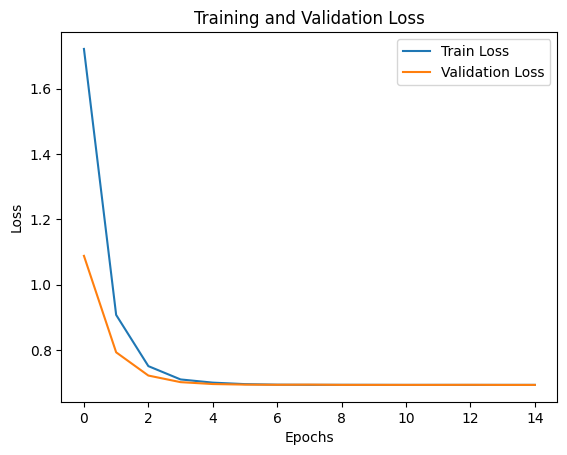

In [19]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [33]:

final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]
final_training_loss = history.history['loss'][-1]
final_validation_loss = history.history['val_loss'][-1]


print("Final Training Accuracy: {:.4f}".format(final_training_accuracy))
print("Final Validation Accuracy: {:.4f}".format(final_validation_accuracy))
print("Final Training Loss: {:.4f}".format(final_training_loss))
print("Final Validation Loss: {:.4f}".format(final_validation_loss))

Final Training Accuracy: 0.4868
Final Validation Accuracy: 0.4866
Final Training Loss: 0.6932
Final Validation Loss: 0.6932


Evaluation on Test Set 1:
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step
Test Set 1 - Accuracy: 0.5813

Test Set 1 - Confusion Matrix:


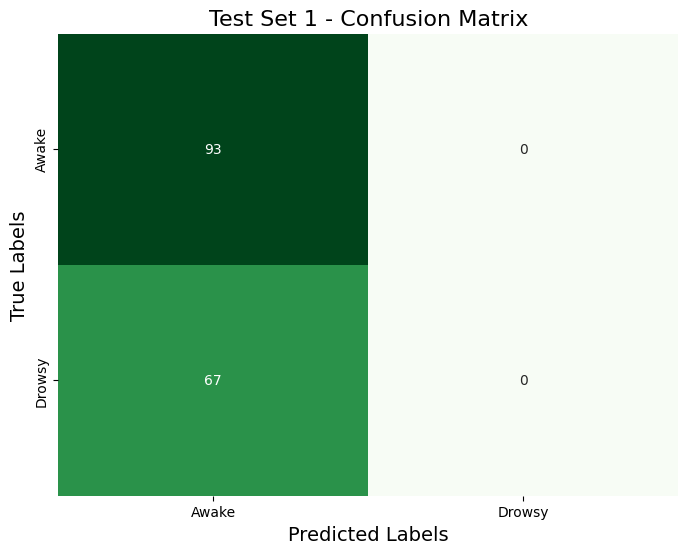

Test Set 1 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.58      1.00      0.74        93
      Drowsy       0.00      0.00      0.00        67

    accuracy                           0.58       160
   macro avg       0.29      0.50      0.37       160
weighted avg       0.34      0.58      0.43       160


Evaluation on Test Set 2:
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step
Test Set 2 - Accuracy: 0.4800

Test Set 2 - Confusion Matrix:


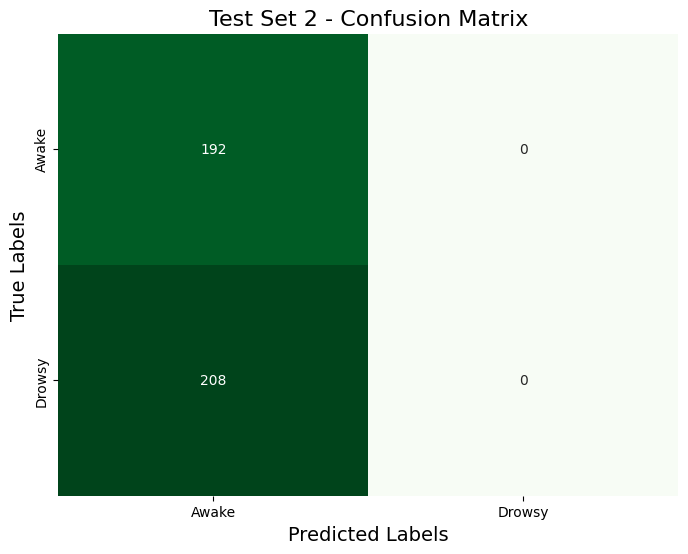

Test Set 2 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.48      1.00      0.65       192
      Drowsy       0.00      0.00      0.00       208

    accuracy                           0.48       400
   macro avg       0.24      0.50      0.32       400
weighted avg       0.23      0.48      0.31       400



In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False
    )
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.title(title, fontsize=16)
    plt.show()

def evaluate_model(model, data_generator, class_names, dataset_name):
    y_pred = model.predict(data_generator)
    y_pred = (y_pred > 0.5).astype(int).flatten()
    y_true = np.concatenate([data_generator[i][1] for i in range(len(data_generator))])
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{dataset_name} - Accuracy: {accuracy:.4f}\n")
    print(f"{dataset_name} - Confusion Matrix:")
    plot_confusion_matrix(y_true, y_pred, class_names, title=f"{dataset_name} - Confusion Matrix")
    print(f"{dataset_name} - Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    print(report)

print("Evaluation on Test Set 1:")
evaluate_model(mobilenet_model, test_gen, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 1")

print("\nEvaluation on Test Set 2:")
evaluate_model(mobilenet_model, new_test_gen, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 2")


In [21]:

mobilenet_model.save("mobilenetsimpleAugmentation.keras")
print("Model saved as 'mobilenetsimpleAugmentation.keras'")


Model saved as 'mobilenetsimpleAugmentation.keras'


### EfficientNetV2B0

In [22]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

base_model = EfficientNetV2B0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in base_model.layers[:200]:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3), name='image_input')
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

efficientnet = Model(inputs, output)

efficientnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

historyEfficientNet = efficientnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stopping],
    batch_size=32
)



Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.5165 - loss: 2.2269 - val_accuracy: 0.4866 - val_loss: 0.9396
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.4992 - loss: 0.8531 - val_accuracy: 0.4866 - val_loss: 0.7264
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.4980 - loss: 0.7225 - val_accuracy: 0.5134 - val_loss: 0.7041
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.4968 - loss: 0.7085 - val_accuracy: 0.5134 - val_loss: 0.6978
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.4977 - loss: 0.6990 - val_accuracy: 0.5134 - val_loss: 0.6946
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.5038 - loss: 0.6943 - val_accuracy: 0.5134 - val_loss: 0.6933
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.5078 - loss: 0.6935 - val_accuracy: 0.5134 - val_loss: 0.6933
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.4968 - loss: 0.6948 - val_accuracy: 0.5134 - v

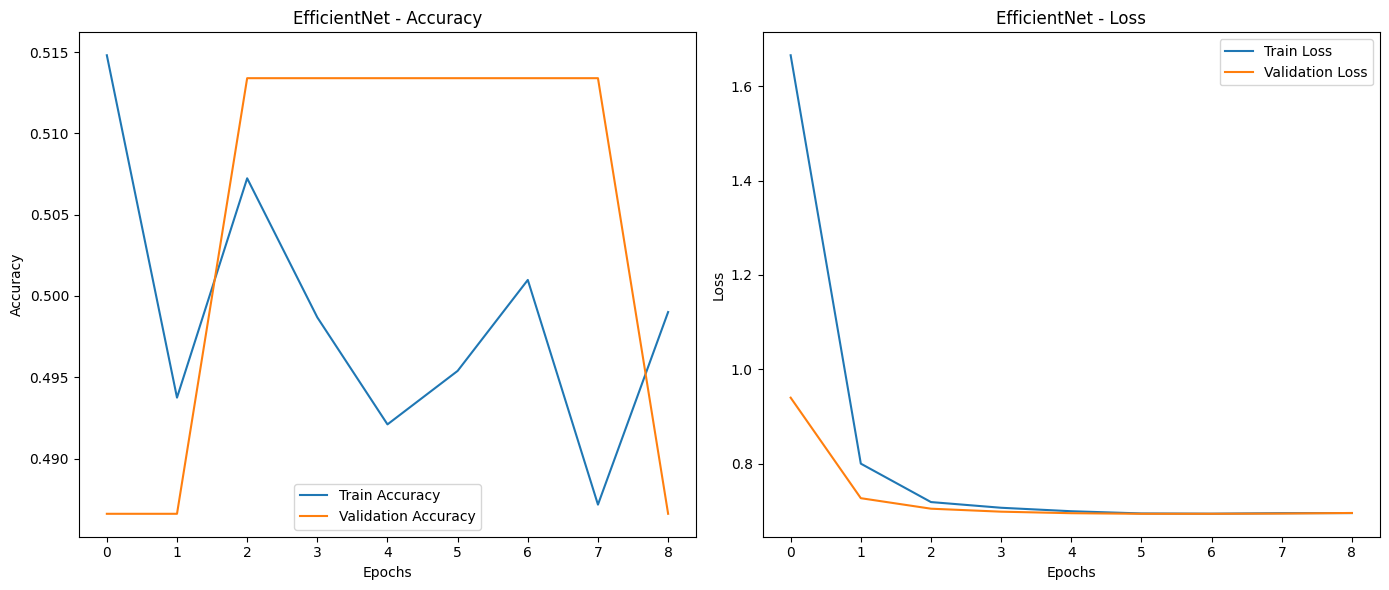

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(historyEfficientNet.history['accuracy'], label='Train Accuracy')
plt.plot(historyEfficientNet.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNet - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historyEfficientNet.history['loss'], label='Train Loss')
plt.plot(historyEfficientNet.history['val_loss'], label='Validation Loss')
plt.title('EfficientNet - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [34]:

final_training_accuracy = historyEfficientNet.history['accuracy'][-1]
final_validation_accuracy = historyEfficientNet.history['val_accuracy'][-1]
final_training_loss = historyEfficientNet.history['loss'][-1]
final_validation_loss = historyEfficientNet.history['val_loss'][-1]


print("Final Training Accuracy: {:.4f}".format(final_training_accuracy))
print("Final Validation Accuracy: {:.4f}".format(final_validation_accuracy))
print("Final Training Loss: {:.4f}".format(final_training_loss))
print("Final Validation Loss: {:.4f}".format(final_validation_loss))

Final Training Accuracy: 0.4990
Final Validation Accuracy: 0.4866
Final Training Loss: 0.6948
Final Validation Loss: 0.6951


Evaluation on Test Set 1:
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 364ms/step
Test Set 1 - Accuracy: 0.5813

Test Set 1 - Confusion Matrix:


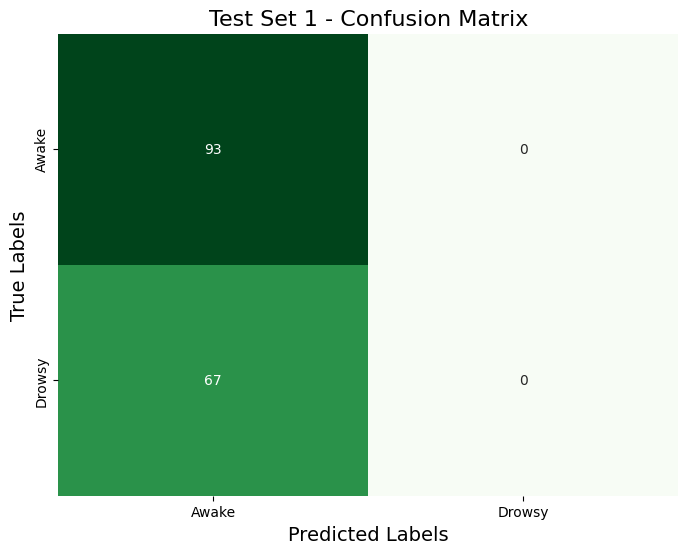

Test Set 1 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.58      1.00      0.74        93
      Drowsy       0.00      0.00      0.00        67

    accuracy                           0.58       160
   macro avg       0.29      0.50      0.37       160
weighted avg       0.34      0.58      0.43       160


Evaluation on Test Set 2:
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step
Test Set 2 - Accuracy: 0.4800

Test Set 2 - Confusion Matrix:


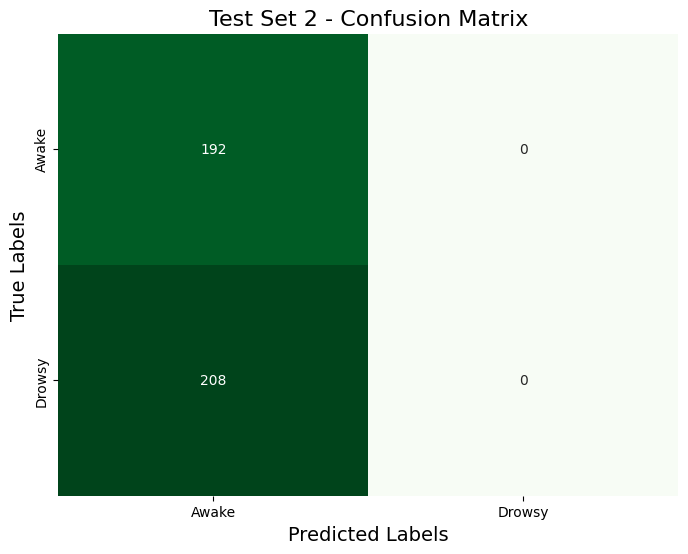

Test Set 2 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.48      1.00      0.65       192
      Drowsy       0.00      0.00      0.00       208

    accuracy                           0.48       400
   macro avg       0.24      0.50      0.32       400
weighted avg       0.23      0.48      0.31       400



In [24]:
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False
    )
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.title(title, fontsize=16)
    plt.show()

def evaluate_model(model, data_generator, class_names, dataset_name):
    y_pred = model.predict(data_generator)
    y_pred = (y_pred > 0.5).astype(int).flatten()
    y_true = np.concatenate([data_generator[i][1] for i in range(len(data_generator))])
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{dataset_name} - Accuracy: {accuracy:.4f}\n")
    print(f"{dataset_name} - Confusion Matrix:")
    plot_confusion_matrix(y_true, y_pred, class_names, title=f"{dataset_name} - Confusion Matrix")
    print(f"{dataset_name} - Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    print(report)

print("Evaluation on Test Set 1:")
evaluate_model(efficientnet, test_gen, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 1")

print("\nEvaluation on Test Set 2:")
evaluate_model(efficientnet, new_test_gen, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 2")


In [25]:

efficientnet.save("efficientnetsimpleAugmentation.keras")
print("Model saved as 'efficientnetsimpleAugmentation.keras'")


Model saved as 'efficientnetsimpleAugmentation.keras'


### ResNet50

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in base_model.layers[:140]:
    layer.trainable = False

input_layer = Input(shape=(224, 224, 3), name='input')
x = base_model(input_layer)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

resnet = Model(inputs=input_layer, outputs=output)

resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

historyResnet = resnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stopping],
    batch_size=32
)

Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 421s 4s/step - accuracy: 0.5073 - loss: 2.1238 - val_accuracy: 0.5134 - val_loss: 0.8957
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 468s 5s/step - accuracy: 0.4963 - loss: 0.8353 - val_accuracy: 0.4866 - val_loss: 0.7363
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 407s 4s/step - accuracy: 0.5100 - loss: 0.7248 - val_accuracy: 0.5134 - val_loss: 0.7043
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 439s 5s/step - accuracy: 0.5053 - loss: 0.7017 - val_accuracy: 0.4866 - val_loss: 0.6964
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 497s 5s/step - accuracy: 0.4987 - loss: 0.6957 - val_accuracy: 0.5134 - val_loss: 0.6940
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 417s 4s/step - accuracy: 0.4872 - loss: 0.6942 - val_accuracy: 0.4866 - val_loss: 0.6935
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.4961 - loss: 0.6934 - val_accuracy: 0.4866 - val_loss: 0.6933
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 438s 5s/step - accuracy: 0.4977 - loss: 0.6933 - val_accuracy: 0.4866 - v

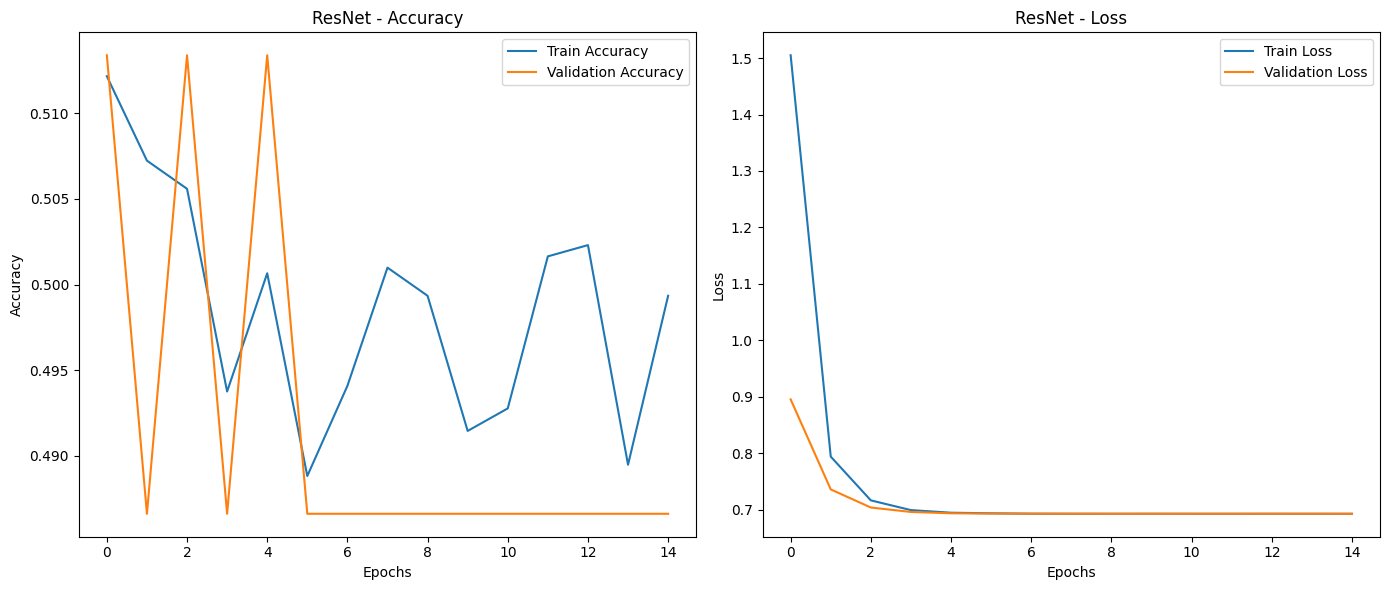

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(historyResnet.history['accuracy'], label='Train Accuracy')
plt.plot(historyResnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historyResnet.history['loss'], label='Train Loss')
plt.plot(historyResnet.history['val_loss'], label='Validation Loss')
plt.title('ResNet - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [32]:

final_training_accuracy = historyResnet.history['accuracy'][-1]
final_validation_accuracy = historyResnet.history['val_accuracy'][-1]
final_training_loss = historyResnet.history['loss'][-1]
final_validation_loss = historyResnet.history['val_loss'][-1]

print("Final Training Accuracy: {:.4f}".format(final_training_accuracy))
print("Final Validation Accuracy: {:.4f}".format(final_validation_accuracy))
print("Final Training Loss: {:.4f}".format(final_training_loss))
print("Final Validation Loss: {:.4f}".format(final_validation_loss))


Final Training Accuracy: 0.4993
Final Validation Accuracy: 0.4866
Final Training Loss: 0.6932
Final Validation Loss: 0.6932


Evaluation on Test Set 1:
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step
Test Set 1 - Accuracy: 0.4188

Test Set 1 - Confusion Matrix:


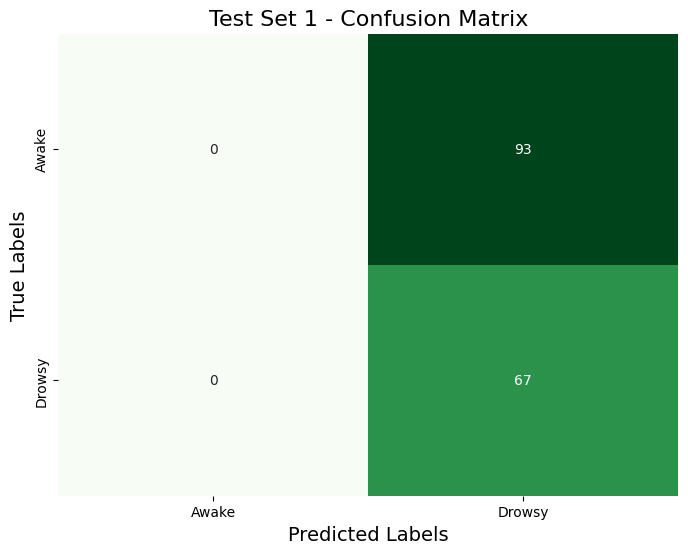

Test Set 1 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.00      0.00      0.00        93
      Drowsy       0.42      1.00      0.59        67

    accuracy                           0.42       160
   macro avg       0.21      0.50      0.30       160
weighted avg       0.18      0.42      0.25       160


Evaluation on Test Set 2:
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step
Test Set 2 - Accuracy: 0.5200

Test Set 2 - Confusion Matrix:


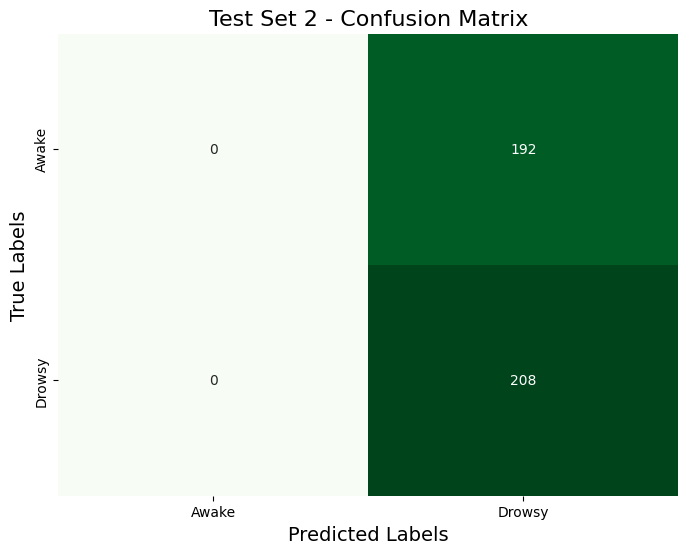

Test Set 2 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.00      0.00      0.00       192
      Drowsy       0.52      1.00      0.68       208

    accuracy                           0.52       400
   macro avg       0.26      0.50      0.34       400
weighted avg       0.27      0.52      0.36       400



In [28]:
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False
    )
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.title(title, fontsize=16)
    plt.show()

def evaluate_model(model, data_generator, class_names, dataset_name):
    y_pred = model.predict(data_generator)
    y_pred = (y_pred > 0.5).astype(int).flatten()
    y_true = np.concatenate([data_generator[i][1] for i in range(len(data_generator))])
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{dataset_name} - Accuracy: {accuracy:.4f}\n")
    print(f"{dataset_name} - Confusion Matrix:")
    plot_confusion_matrix(y_true, y_pred, class_names, title=f"{dataset_name} - Confusion Matrix")
    print(f"{dataset_name} - Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    print(report)

print("Evaluation on Test Set 1:")
evaluate_model(resnet, test_gen, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 1")

print("\nEvaluation on Test Set 2:")
evaluate_model(resnet, new_test_gen, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 2")


In [29]:
resnet.save("resnetsimpleAugmentation.keras")
print("Model saved as 'resnetsimpleAugmentation.keras'")


Model saved as 'resnetsimpleAugmentation.keras'
